### KNN Regression on California Housing Dataset

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Open the housing data


In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
print("DATA SHAPE:", housing.shape)
housing.head()

DATA SHAPE: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Build full pipeline for the data analysis following the example of the notebook.
 Hint: the main part requested to change is the algorithm used (KNN regression)


#### Considerations for building pipeline:

- Make your notebook as compact as possible. 
- Split data into training and testing sets below.
- Convert all categorical data to one-hot vectors below
- Normalize all non-categorical data 
-  Perform KNN regression using a variety of values for n_neighbors (K) between 1 and 10 and both "uniform" and "distance" weights via a grid search where  *housing_labels* is the output and all other features are the input (similar to as seen in lecture two.)

In [76]:
housing.describe()
# housing['ocean_proximity'].value_counts()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1bacaeec88>,
      dtype=object)

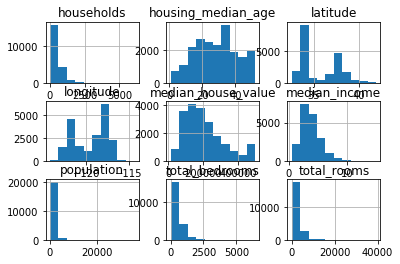

In [77]:
# housing_numericals = housing.copy()
# housing_numericals.drop('ocean_proximity', axis=1, inplace=True)
housing.hist()

In [78]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

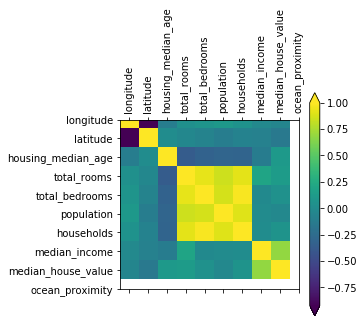

In [20]:
# housing.info()
# housing['ocean_proximity'].value_counts()
# pd.plotting.scatter_matrix(housing)

plt.matshow(housing.corr())
plt.xticks(range(len(housing.columns)), housing.columns,rotation=90,fontsize=10)
plt.yticks(range(len(housing.columns)), housing.columns,fontsize=10)
plt.colorbar(extend='both')
plt.show()
# housing.corr()

In [ ]:
# looks like median_income is heavily correlated to house value! Going to create a stratified test set to ensure equal representation.

3    10875
2     4946
1     2457
4     2362
Name: income_cat, dtype: int64

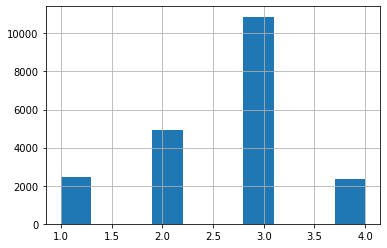

In [79]:
housing['income_cat'] = pd.cut(housing['median_income'],bins=[0,2,3,6, np.inf], labels=[1,2,3,4])
housing['income_cat'].hist()
housing['income_cat'].value_counts()

In [80]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

Compare the stratefied distribution of med_income buckets in test set to the full set.

In [81]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.526890
2    0.239583
1    0.119186
4    0.114341
Name: income_cat, dtype: float64

In [82]:
housing["income_cat"].value_counts() / len(housing)

3    0.526890
2    0.239632
1    0.119041
4    0.114438
Name: income_cat, dtype: float64

In [83]:
for x in (strat_train_set,strat_test_set):
    x.drop('income_cat',axis=1, inplace=True)
    
strat_train_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 7009 to 19311
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16347 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


Prepping our train and test sets.

In [84]:
housing = strat_train_set.copy()
housing.drop('median_house_value', axis=1,inplace=True)
housing_labels = strat_train_set["median_house_value"].copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 7009 to 19311
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16347 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [85]:
# add a nee feature: bedrooms/room ratio
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# get column index
# rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, df, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.df = df
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        col_index = []
        for x in ['total_rooms', 'total_bedrooms', 'population', 'households']:
            col_index.append(self.df.columns.get_loc(x))

        rooms_ix, bedrooms_ix, population_ix, household_ix  = col_index
        
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
       

In [11]:
# testing corr of whole dataset plus new cols

# feature_adder = CombinedAttributesAdder(df=strat_train_set)
# housing_extra_attribs = feature_adder.transform(strat_train_set.values)
# housing_extra_attribs = pd.DataFrame(
#     housing_extra_attribs,
#     columns=list(strat_train_set.columns)+["rooms_per_household", "population_per_household", "bedrooms_per_room"])
# housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
0,-118.07,33.97,36,1887,370,1006,329,3.1554,170700,<1H OCEAN,5.73556,3.05775,0.196078
1,-117.99,33.77,15,2081,531,1617,561,3.4955,160900,<1H OCEAN,3.70945,2.88235,0.255166
2,-119.63,36.64,33,1036,181,620,174,3.4107,110400,INLAND,5.95402,3.56322,0.17471
3,-117.89,33.74,32,660,145,959,113,3.75,159000,<1H OCEAN,5.84071,8.48673,0.219697
4,-118.07,33.88,18,2436,375,1303,386,6.1968,344700,<1H OCEAN,6.31088,3.37565,0.153941


In [251]:
# from sklearn.impute import SimpleImputer

# imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# clean_housing_extra = imp_median.fit_transform(housing_extra_attribs)
# clean_housing_extra = pd.DataFrame(clean_housing_extra,columns=housing_extra_attribs.columns.tolist())
# # clean_housing_extra.info()
# house_corr = clean_housing_extra.corr()
# house_corr['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688412
rooms_per_household         0.151282
total_rooms                 0.136863
housing_median_age          0.107407
households                  0.068238
total_bedrooms              0.051805
population_per_household   -0.020066
population                 -0.023270
longitude                  -0.044983
latitude                   -0.144820
bedrooms_per_room          -0.254015
Name: median_house_value, dtype: float64

In [255]:
# try dropping less correlated columns - even though they seem to have statistical significance at p < 0.05
# smaller_housing = housing.copy()
# smaller_housing.drop(columns = ['longitude', 'latitude'],inplace=True)

# ended up not using this trimmed dataset as it didn't result in better result in training KNN.

In [86]:
# build pipeline ot transform data (cat cols to onehot, handle for missing num cols, standardize num cols)
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), CombinedAttributesAdder(df=housing),StandardScaler())
log_pipeline = make_pipeline(FunctionTransformer(np.log1p, validate=True))

housing_num = housing.select_dtypes(include=[np.number])
num_attribs = list(housing_num)
log_attribs = ['housing_median_age', 'total_rooms', 'population', 'households', 'median_income']
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("log", log_pipeline, log_attribs),
        ("cat", OneHotEncoder(), cat_attribs)
    ])


In [87]:
housing_prepared = full_pipeline.fit_transform(housing)

In [88]:
# housing_prepared = log_pipeline.fit_transform(log_pipeline)
housing_prepared.shape

(16512, 21)

In [279]:
# # trying our smaller data set

# # del housing_num, num_attribs, log_attribs, cat_attribs

# num_pipeline = make_pipeline(SimpleImputer(strategy="median"), CombinedAttributesAdder(df=smaller_housing, add_bedrooms_per_room=True),StandardScaler())
# log_pipeline = make_pipeline(FunctionTransformer(np.log1p, validate=True))

# housing_num = smaller_housing.select_dtypes(include=[np.number])
# num_attribs = list(housing_num)
# # num_attribs
# cat_attribs = ["ocean_proximity"]
# log_attribs = ['housing_median_age', 'total_rooms', 'population', 'households', 'median_income']

# full_small_pipeline = ColumnTransformer([
#         ("num", num_pipeline, num_attribs),
#         ("log", log_pipeline, log_attribs),
#         ("cat", OneHotEncoder(), cat_attribs),
#     ])


In [280]:
# # smaller_housing.info()
# housing_prepared = full_small_pipeline.fit_transform(smaller_housing)

In [37]:
# housing_prepared.shape

(16512, 21)

First we try out KNN as default.

In [93]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn.fit(housing_prepared, housing_labels)

y_pred = knn.predict(housing_prepared)

knn_rmse = np.sqrt(mean_squared_error(housing_labels, y_pred))
knn_rmse

# before log transform rmse: 49521.130387713514
# after log transforming some cols: 48988.296502586556

# after removing long, lat rmse: 52515.87454156765

48988.296502586556

Here we take a detour into RandomForestRegressor to utilize its Feature Importnaces method (since KNN doens't have one) to try reducing num_features used.

In [94]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(housing_prepared, housing_labels);

y_pred = rf.predict(housing_prepared)

rf_pred_score = np.sqrt(mean_squared_error(housing_labels, y_pred))

rf_pred_score

18497.906975058

Trying cross val on Random Forest.

In [90]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_scores = cross_val_score(rf, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rf_scores_rmse_scores = np.sqrt(-rf_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rf_scores_rmse_scores)

# Scores: [51033.61756625 50606.76787941 49324.10931668 50526.68340013
#  50129.70007561 47689.51816919 50420.06038147 51034.90252945
#  49695.69478771 49366.8086847 ]
# Mean: 49982.78627905954
# Standard deviation: 962.494067735034

Scores: [51033.61756625 50606.76787941 49324.10931668 50526.68340013
 50129.70007561 47689.51816919 50420.06038147 51034.90252945
 49695.69478771 49366.8086847 ]
Mean: 49982.78627905954
Standard deviation: 962.494067735034


Finding the best params for Random Forest so that we can later compare our final KNN model to this one.

In [29]:
?RandomForestRegressor

Init signature:
RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is always the same as the original
input sample size but the samples are drawn with replacement if
`bootstrap=True` (default).

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : integer, optional (default=10)
    The number of trees in the fore

In [27]:
# ?RandomForestRegressor
# rf.get_params()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [28]:
from scipy.stats import randint

rf = RandomForestRegressor()
best_rf = RandomizedSearchCV(rf,param_distributions=random_grid,cv=5, n_jobs = -1, verbose=1, n_iter=100, scoring='neg_mean_squared_error', random_state=42)

best_rf.fit(housing_prepared, housing_labels)

# rnd_search.best_params_
best_rf.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 118.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 129.8min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1557, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
# try out the new best params
rf_best = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='auto', min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1557, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

rf_best.fit(housing_prepared, housing_labels)

y_pred = rf_best.predict(housing_prepared)

rfbest_score = np.sqrt(mean_squared_error(housing_labels, y_pred))
rfbest_score

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 1557 out of 1557 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1557 out of 1557 | elapsed:    1.3s finished


18152.72453168989

In [92]:
scores = cross_val_score(rf_best, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1557 out of 1557 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1557 out of 1557 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paral

Scores: [50722.36523927 50260.34456903 49135.98441814 50055.00169144
 49814.63668623 47317.86642382 50102.44634598 50420.44257002
 49102.66109265 49039.61824602]
Mean: 49597.13672826039
Standard deviation: 941.2315497901909


Now look at feature importances to see if we can remove certain features.

In [45]:
feature_importances = rf_best.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + log_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.24369100593939305, 'median_income'),
 (0.2305224635571421, 'bedrooms_per_room'),
 (0.1438922231388992, 'INLAND'),
 (0.1208275948134601, 'total_rooms'),
 (0.0577576756684662, 'longitude'),
 (0.05432300074820777, 'latitude'),
 (0.026645927291800174, 'housing_median_age'),
 (0.023095911629431976, 'housing_median_age'),
 (0.023079390141580242, 'households'),
 (0.022876332245257414, 'population'),
 (0.010006550812039947, 'total_bedrooms'),
 (0.007243873984726424, 'median_income'),
 (0.0071641667472998535, 'total_rooms'),
 (0.0064750073564447995, 'population'),
 (0.006466924033870593, 'rooms_per_hhold'),
 (0.005715241748040608, 'pop_per_hhold'),
 (0.005712288215653886, 'households'),
 (0.002515215104465619, 'NEAR OCEAN'),
 (0.0011019352275935083, '<1H OCEAN'),
 (0.0007193405262019268, 'NEAR BAY'),
 (0.00016793107002473912, 'ISLAND')]

In [95]:
# try dropping some of the less important features
# updte: this did not help the model! May help the test set though.

housing_trim = pd.DataFrame(housing_prepared,columns=attributes)
housing_trim.drop(columns = ['median_house_value', 'NEAR BAY', 'ISLAND'], axis=1,inplace=True)
housing_trim_labels = strat_train_set["median_house_value"].copy()

housing_trim.info()

housing_trim = housing_trim.values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 19 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
rooms_per_hhold       16512 non-null float64
pop_per_hhold         16512 non-null float64
bedrooms_per_room     16512 non-null float64
<1H OCEAN             16512 non-null float64
INLAND                16512 non-null float64
NEAR OCEAN            16512 non-null float64
dtypes: float64(19)
memory usage: 2.

In [97]:
housing_trim

array([[ 0.75060366, -0.77928422,  0.58222481, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.79051734, -0.87277027, -1.08755128, ...,  1.        ,
         0.        ,  0.        ],
       [-0.0277132 ,  0.46875451,  0.34368537, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8708898 ,  0.37059416, -0.53095925, ...,  1.        ,
         0.        ,  0.        ],
       [-1.13032876,  0.4547316 , -1.08755128, ...,  1.        ,
         0.        ,  0.        ],
       [-1.65419588,  1.28208311, -1.00803813, ...,  1.        ,
         0.        ,  0.        ]])

Back to our best Random Forest with our newly smaller feature list.

In [96]:

rf_best = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='auto', min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1557, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

rf_best.fit(housing_trim, housing_labels)

y_pred = rf_best.predict(housing_trim)

rfbest_score = np.sqrt(mean_squared_error(housing_labels, y_pred))
rfbest_score



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1557 out of 1557 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1557 out of 1557 | elapsed:    1.3s finished


18145.06060701546

In [98]:
# try the trimmed dataset with CV

scores = cross_val_score(rf_best, housing_trim, housing_labels,
                         scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1557 out of 1557 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1557 out of 1557 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paral

Scores: [50787.20894224 50275.99754949 49237.86825859 49945.31149289
 49862.48574818 47360.59566441 50181.42548192 50427.79352048
 49153.12555738 49080.98234064]
Mean: 49631.27945562298
Standard deviation: 931.8389071787957


Even though the Mean score is slightly worse, there is still a possibility that the test set will perform better with this slightly noisier model. Trying to avoid overfitting.

In [24]:

# knn_best = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
#                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
#                     weights='distance')
# knn_best.fit(housing_prepared, housing_labels)

# some_data = housing.iloc[:5]
# some_labels = housing_labels.iloc[:5]
# some_data_prepared = full_pipeline.transform(some_data)


# y_pred = knn_best.predict(some_data_prepared)
# knnbest_rmse = np.sqrt(mean_squared_error(some_labels, y_pred))
# knnbest_rmse



0.0

Back to KNN to try tweaking its params with GridSearch and RandomizedCV

In [326]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [327]:
# using full dataset (not the trimmed version, for now)
scores = cross_val_score(knn, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [62427.38495922 61545.86143142 61463.20526689 59092.76559755
 62683.89489777 58585.51800492 60411.59041866 61030.7603823
 60843.19638083 60410.7796537 ]
Mean: 60849.49569932447
Standard deviation: 1238.755206785948


In [328]:
# Perform KNN regression using a variety of values for n_neighbors (K) between 1 and 10 
# and both "uniform" and "distance" weights via a grid search 
# where  *housing_labels* is the output and all other features are the input 
# (similar to as seen in lecture two.)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
    
knn = KNeighborsRegressor()

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_neighbors': [5,6,7,8,9,10,11,12,13,14,15], 'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
    },
    # then try 6 (2×3) combinations with bootstrap set as False
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(knn, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, verbose=2)
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV] metric=minkowski, n_neighbors=5, weights=uniform ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . metric=minkowski, n_neighbors=5, weights=uniform, total=   0.5s
[CV] metric=minkowski, n_neighbors=5, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] . metric=minkowski, n_neighbors=5, weights=uniform, total=   0.3s
[CV] metric=minkowski, n_neighbors=5, weights=uniform ................
[CV] . metric=minkowski, n_neighbors=5, weights=uniform, total=   0.4s
[CV] metric=minkowski, n_neighbors=5, weights=uniform ................
[CV] . metric=minkowski, n_neighbors=5, weights=uniform, total=   0.4s
[CV] metric=minkowski, n_neighbors=5, weights=uniform ................
[CV] . metric=minkowski, n_neighbors=5, weights=uniform, total=   0.5s
[CV] metric=minkowski, n_neighbors=5, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=5, weights=distance, total=   0.5s
[CV] metric=minkowski, n_neighbors=5, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=5, weights=distance, total=   0.3s
[CV] metric=minkowski, n_neighbors=5, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=5, weights=distance, total=   0.5s
[CV] metric=minkowski, n_neighbors=5, weights=distance ...............
[CV]  

[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:  8.9min finished


{'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}

In [313]:
print(grid_search.best_estimator_)
# feature_importances = grid_search.best_estimator_.feature_importances_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='distance')


In [223]:
cvgrid = grid_search.cv_results_
for mean_score, params in zip(cvgrid["mean_test_score"], cvgrid["params"]):
    print(np.sqrt(-mean_score), params)

61144.144666930835 {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
60745.17066067925 {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
60624.02086206421 {'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'uniform'}
60178.95903752728 {'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'distance'}
60403.78739053305 {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform'}
59909.83861155471 {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}
60300.86232078644 {'metric': 'minkowski', 'n_neighbors': 8, 'weights': 'uniform'}
59778.81261312459 {'metric': 'minkowski', 'n_neighbors': 8, 'weights': 'distance'}
60249.47589700753 {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'uniform'}
59700.28187013157 {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}
60238.776775255064 {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'uniform'}
59665.82069939555 {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
60241.

In [314]:
# test out our best params
knnbest = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=2, n_neighbors=11, p=2,
                    weights='distance')

scores = cross_val_score(knn, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)

knn_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(knn_rmse_scores)

Scores: [62350.39873138 60494.04990595 60868.50499658 61163.35319944
 60827.61843233]
Mean: 61140.78505313587
Standard deviation: 640.9603238918779


Now try RandomizedSearchCV

In [321]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_neighbors': randint(low=5, high=20),
        'weights': ['uniform', 'distance'],
        'leaf_size': randint(low=30, high=40),
        'metric': ['minkowski', 'euclidean']
    }

rnd_search = RandomizedSearchCV(knn, param_distributions=param_distribs, n_jobs=2,
                                n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

# rnd_search.best_params_
rnd_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=32, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='distance')

In [225]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
# gridsearch best score 59650.894142275036
# random search best score 59650.894142275036

60427.96692969777 {'leaf_size': 36, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
59909.83861155471 {'leaf_size': 37, 'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}
60241.38011652888 {'leaf_size': 32, 'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'uniform'}
61438.26329050499 {'leaf_size': 37, 'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'distance'}
66205.66298388786 {'leaf_size': 37, 'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
76182.30181880607 {'leaf_size': 35, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
60308.644766740115 {'leaf_size': 39, 'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}
59665.82069939555 {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
63203.674759297166 {'leaf_size': 32, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
60249.47589700753 {'leaf_size': 32, 'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'uniform'}

In [102]:
# test out our best random params
kbbbest_random = KNeighborsRegressor(algorithm='auto', leaf_size=33, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='distance')


scores = cross_val_score(kbbbest_random, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)

knn_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(knn_rmse_scores)

# Mean: 59648.50477609326
# Standard deviation: 533.9006923404554

Scores: [60689.53684657 59294.63995931 59617.39747335 59313.17164435
 59327.77795689]
Mean: 59648.50477609326
Standard deviation: 533.9006923404554


Trying out SelectKBest and SelectFromModel - they did not help

In [317]:
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import mutual_info_regression

# X_new = SelectKBest(mutual_info_regression, k=10).fit_transform(housing_prepared, housing_labels)
# X_new.shape

(16512, 10)

In [320]:
# rnd_search_best = RandomizedSearchCV(knn, param_distributions=param_distribs, n_jobs=2,
#                                 n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
# rnd_search_best.fit(X_new, housing_labels)

# print(rnd_search_best.best_estimator_)

# cvresbest = rnd_search_best.cv_results_

# for mean_score, params in zip(cvresbest["mean_test_score"], cvresbest["params"]):
#     print(np.sqrt(-mean_score), params)

KNeighborsRegressor(algorithm='auto', leaf_size=33, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='distance')
63953.29927527397 {'leaf_size': 36, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
63729.61617472526 {'leaf_size': 37, 'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}
63800.33495145485 {'leaf_size': 32, 'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'uniform'}
65221.82708534894 {'leaf_size': 37, 'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'distance'}
69949.94226977209 {'leaf_size': 37, 'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
79664.60831940325 {'leaf_size': 35, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
63846.57554858102 {'leaf_size': 39, 'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}
63252.24370650049 {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
67142.7163777

In [322]:
# bestknn = KNeighborsRegressor(algorithm='auto', leaf_size=33, metric='euclidean',
#                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
#                     weights='distance')

# scores = cross_val_score(bestknn, X_new, housing_labels,
#                          scoring="neg_mean_squared_error", cv=5)

# knn_rmse_scores = np.sqrt(-scores)

# def display_scores(scores):
#     print("Scores:", scores)
#     print("Mean:", scores.mean())
#     print("Standard deviation:", scores.std())

# display_scores(knn_rmse_scores)

Scores: [63927.40081619 61891.6309268  63055.15873474 63548.29822687
 63376.55499009]
Mean: 63159.808738938256
Standard deviation: 693.7329750367388


Now we have our final KNN model with the best params. Split up test set and try our best parameters on full dataset.

In [99]:
x_test = strat_test_set.copy()
x_test.drop('median_house_value', axis=1,inplace=True)
y_test = strat_test_set["median_house_value"].copy()

In [100]:
x_test.shape

(4128, 9)

In [101]:
x_test = full_pipeline.transform(x_test)
x_test.shape

(4128, 21)

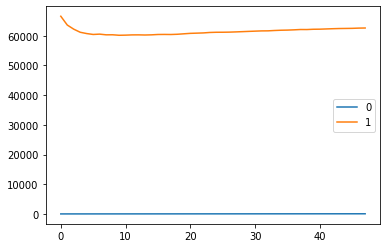

In [365]:
# for kicks, let's just visualize this.
rmse_list = []
for k in range(2,50):
    knn_looped = KNeighborsRegressor(algorithm='auto', metric='euclidean', n_neighbors=k, p=2,
                    weights='distance')
    knn_looped.fit(housing_prepared, housing_labels)
    y_pred = knn_looped.predict(x_test)
    rmse_list.append((k,np.sqrt(mean_squared_error(y_test, y_pred))))

score_df = pd.DataFrame(rmse_list)
score_df.plot()

Fitting the best model to test X and predicting Y on FULL dataset.

In [372]:
kbbbest_random.fit(housing_prepared, housing_labels)

KNeighborsRegressor(algorithm='auto', leaf_size=33, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='distance')

In [373]:
y_pred = kbbbest_random.predict(x_test)
predict_score = np.sqrt(mean_squared_error(y_test, y_pred))
predict_score

60133.81312286888

Now we try the dataset with fewer featues an see if we get a better rmse score on the trimmed set.

In [111]:
xtrim_test = pd.DataFrame(x_test,columns=attributes)
xtrim_test.drop(columns = ['NEAR BAY', 'ISLAND'], axis=1,inplace=True)

xtrim_test = xtrim_test.values

In [110]:
kbbbest_random.fit(housing_trim, housing_labels)
y_pred = kbbbest_random.predict(xtrim_test)
predict_score = np.sqrt(mean_squared_error(y_test, y_pred))
predict_score

60119.812452597354

I guess that's a little better?

In [113]:
# let's also just try our best RandomForest model on the test set.

rf_best.fit(housing_trim, housing_labels)
y_pred = rf_best.predict(xtrim_test)
rfbest_score = np.sqrt(mean_squared_error(y_test, y_pred))
rfbest_score



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 1557 out of 1557 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1557 out of 1557 | elapsed:    0.6s finished


49329.55077139079

That's much better.

### Conclusions
For what values of n_neighbors and weight does KNeighborsRegressor perform the best? Does it perform as well on the housing data as the linear regressor from the lectures? Why do you think this is?

<pre>According to GridSearch and RandomSearch, k = 11 is the best parameter for the lowest rmse score. It does not seem to matter whether we use Euclidean distnace or not (which I was surprised by).

I also chose to log-transform some of the numerical data to bring it to normal distribution. This seems to have helped the training data score improve a little (49521.13 from 48988.30). 

Sicne Feature_Importances doesn't apply to KNNRegressor, I first used correlation instead to see if I could remove redundant features. CHecking the correlation matrix, I ran significance testing on the lowest-correlating variables in the trianing set and realized they were all significant at p-value less than 0.05. I went ahead and tested removing a couple of them anyway (for science!), and realized the model got worse in training. I've hidden a lot of this meandering in the notebook.

However, I tried out a RandomForestRegressor to gain access to Feature_importances method, and was able to improve the model by then removing a couple of low-ranking features. The KNN model then returned a small improvement in the final test set, but perhaps going back and removing more features could help. Interstingly, this model performed worse in training when given fewer features, but better in testing.

I think this model doesn't perform much better than the models in the sample notebook. I'm not sure if it's because KNNRegressor is limited in how well it can do this task, or if I haven't feature-engineered enough! RandomForest, however, turned out a much better result.
</pre>

### Read appending B

- Reflect on your last data project, read appendix B. Then, write down a few of the checklist items that your last data project could have used. If you have not yet done a data project, then write down a few of the items that you found most interesting.


I find ensemble models interesting, as well as using things like Voting to find the best result. I have not used this in a real-life scenario yet. I think it'd be a really interesting skill to be able to manipulate multiple models to produce the best outcome. 
Deployement is anotehr area I'm unfamiliar with. Would be extremely useful to learn how to monitor the health of your model.

### Submit your notebook

Submit your solution to Quercus
Make sure you rename your notebook to    
W2_UTORid.ipynb    
Example W2_adfasd01.ipynb
